### Ticketmaster Tour Data: Can we predict revenue & venue capacity utilization?

**Context**

Imagine you are an independent touring musican armed with the latest Ticketmaster tour sales data available from touringdata.org and you would like to plan where to have your next show or perhaps a performance tour. Using the available data from Ticketmaster can we make informed decisions about where to play to meet revenue requirements or at least play to rooms full of fans?

**Overview**

The goal of this project is to use data visualizations and probability distributions to distinguish between events that maximized revenue and/or venue capacity utilization and those that did not.

**Data**

touringdata.org allows access to this Ticketmaster touring data via year-specific master documents from 2024 onward via the Patreon link: https://www.patreon.com/c/touringdataLinks to an external data-hosting site.

**Deliverables**

This notebook will deliver brief report that highlights the differences between events that maximized revenue and/or venue capacity utilization and those that did not. Additionally an appropriate predictive model will be proposed.





### Data Description

The attributes of this data set include:
- Event Start Date
- Event End Date
- Number of Shows
- Artist Name
- Revenue (USD)
- Tickets Sold
- Estimated Capacity
- Capacity Utilization (%)
- Venue
- City
- Country

This notebook performs complete data cleaning and enrichment:
1. ✅ Data cleaning (dates, whitespace, duplicates, generate derived metrics)
2. ✅ City → State lookup (for US cities)
3. ✅ Artist → Genre lookup
4. ✅ Save enriched dataset
5. ✅ Exploritory Data Analysis
6. ✅ Initial Model Generation

In [99]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
prefix = '/content/drive/MyDrive/Colab Notebooks/tour-data-eda/'



Mounted at /content/drive


## 📦 Setup & Configuration

### API Credentials (Geographical and Music Genre API lookups for data enrichment)
Enter your API credentials here (or leave blank to use free APIs):

In [100]:
image_path = 'images/'
try:
  image_path = prefix + image_path
except NameError:
  pass
data_path = 'data/'
try:
  data_path = prefix + data_path
except NameError:
  pass
lib_path = 'lib/'
try:
  lib_path = prefix + lib_path
except NameError:
  pass

print(f"Image path: {image_path}")
print(f"Data path: {data_path}")
print(f"Library path: {lib_path}")

sys.path.append(lib_path)

Image path: /content/drive/MyDrive/Colab Notebooks/tour-data-eda/images/
Data path: /content/drive/MyDrive/Colab Notebooks/tour-data-eda/data/
Library path: /content/drive/MyDrive/Colab Notebooks/tour-data-eda/lib/


In [113]:
# ============================================================================
# CONFIGURATION - IMPORT FROM SECRETS FILE
# ============================================================================

# Input/Output Files
INPUT_FILE = data_path + '2024_2025_MasterDocument.csv'
OUTPUT_FILE = data_path + '2024_2025_MasterDocument_enriched.csv'

# Try to import API credentials from my_secrets.py file
try:
    from my_secrets import (
        SPOTIFY_CLIENT_ID,
        SPOTIFY_CLIENT_SECRET,
        GOOGLE_API_KEY,
        LASTFM_API_KEY
    )
    print("✓ Loaded API credentials from secrets.py")
except ImportError:
    print("⚠ No secrets.py file found - using free APIs")
    print("  To use premium APIs, create secrets.py with your credentials")
    print("  See: secrets_template.py for example")
    SPOTIFY_CLIENT_ID = ''
    SPOTIFY_CLIENT_SECRET = ''
    GOOGLE_API_KEY = ''
    LASTFM_API_KEY = ''

# API Provider Selection
CITY_PROVIDER = 'google' if GOOGLE_API_KEY else 'nominatim'
ARTIST_PROVIDER = 'spotify' if SPOTIFY_CLIENT_ID else 'musicbrainz'

print("\n✓ Configuration loaded")
print(f"  Input file: {INPUT_FILE}")
print(f"  Output file: {OUTPUT_FILE}")
print(f"  City provider: {CITY_PROVIDER}")
print(f"  Artist provider: {ARTIST_PROVIDER}")
if SPOTIFY_CLIENT_ID:
    print(f"  ✓ Spotify credentials loaded")
if GOOGLE_API_KEY:
    print(f"  ✓ Google API key loaded")

✓ Loaded API credentials from secrets.py

✓ Configuration loaded
  Input file: /content/drive/MyDrive/Colab Notebooks/tour-data-eda/data/2024_2025_MasterDocument.csv
  Output file: /content/drive/MyDrive/Colab Notebooks/tour-data-eda/data/2024_2025_MasterDocument_enriched.csv
  City provider: google
  Artist provider: spotify
  ✓ Spotify credentials loaded
  ✓ Google API key loaded


## 📚 Import Libraries

In [103]:
import pandas as pd
import numpy as np
import json
import time
from datetime import datetime
from pathlib import Path

# Import our external lookup modules
from external_city_lookup import CityStateLookup
from external_artist_lookup import ArtistGenreLookup

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 📊 Load Data

In [114]:
# Load the raw dataset from touringdata.org
print(f"Loading {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

print(f"\n✓ Loaded {len(df):,} rows, {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")


Loading /content/drive/MyDrive/Colab Notebooks/tour-data-eda/data/2024_2025_MasterDocument.csv...

✓ Loaded 7,776 rows, 14 columns

Columns: ['Event Date', 'Event Date.1', 'Shows', 'Artist', 'Revenue (USD)', 'Tickets Sold', 'Capacity', '%', 'Venue', 'City', 'Country', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']


## 🧹 STEP 1: Data Cleaning

Clean dates, whitespace, duplicates, and add calculated fields.

In [115]:
# Store original count
original_rows = len(df)
print(f"\nOriginal dataset: {original_rows:,} rows")

# 1. Clean column names
df.columns = df.columns.str.strip()

# 2. Drop empty columns
empty_cols = [col for col in df.columns if col.startswith('Unnamed:')]
if empty_cols:
    df = df.drop(columns=empty_cols)
    print(f"✓ Dropped {len(empty_cols)} empty columns: {empty_cols}")

# 3. Clean dates
print("\n📅 Cleaning dates...")
# Strip and check for malformed dates
# Fix only the year 3025 typo (not within other numbers) and strip whitespace
df['Event Date'] = df['Event Date'].str.strip().str.replace('/3025', '/2025')
df['Event Date.1'] = df['Event Date.1'].str.strip().str.replace('/3025', '/2025')

# Convert dates with error handling
df['Event Date'] = pd.to_datetime(df['Event Date'], format='%m/%d/%Y', errors='coerce')
df['Event Date.1'] = pd.to_datetime(df['Event Date.1'], format='%m/%d/%Y', errors='coerce')

# Clean the percentage column
df['%'] = df['%'].str.rstrip('%').astype(float) / 100

# Add temporal columns
df['Year-Month'] = df['Event Date'].dt.to_period('M')
df['Month'] = df['Event Date'].dt.month
df['Year'] = df['Event Date'].dt.year
df['DayOfWeek'] = df['Event Date'].dt.day_name()

# 5. Remove duplicates
print("\n🔍 Checking for duplicates...")
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates} duplicate rows")
else:
    print("✓ No duplicates found")

# 6. Add calculated fields
print("\n➕ Adding calculated fields...")

# Average Ticket Price
if 'Revenue (USD)' in df.columns and 'Tickets Sold' in df.columns:
    df['Avg Ticket Price'] = df['Revenue (USD)'] / df['Tickets Sold']
    print("✓ Added 'Avg Ticket Price' column")

# Capacity Utilization
if 'Tickets Sold' in df.columns and 'Capacity' in df.columns:
    df['Capacity Utilization (%)'] = (df['Tickets Sold'] / df['Capacity'] * 100).round(2)
    print("✓ Added 'Capacity Utilization (%)' column")

print(f"\n✅ Data cleaning complete! Final: {len(df):,} rows")
print(f"   Removed: {original_rows - len(df)} rows")
# Save cleaned data
df.to_csv(data_path + 'cleaned_concerts.csv', index=False)


Original dataset: 7,776 rows
✓ Dropped 3 empty columns: ['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13']

📅 Cleaning dates...

🔍 Checking for duplicates...
✓ Removed 2 duplicate rows

➕ Adding calculated fields...
✓ Added 'Avg Ticket Price' column
✓ Added 'Capacity Utilization (%)' column

✅ Data cleaning complete! Final: 7,774 rows
   Removed: 2 rows


## 🗺️ STEP 2: City-State Enrichment

Add State column for US cities using external API.

In [116]:
if 'City' not in df.columns or 'Country' not in df.columns:
    print("⚠ Warning: City or Country column not found - skipping city enrichment")
else:
    # Initialize lookup service
    city_lookup = CityStateLookup()

    # Load existing mapping
    try:
        with open(data_path + 'city_state_mapping.json', 'r') as f:
            city_mapping = json.load(f)
        print(f"✓ Loaded existing mapping: {len(city_mapping)} cities")
    except FileNotFoundError:
        city_mapping = {}
        print("Starting with empty city mapping")

    # Find US cities
    us_cities = df[df['Country'] == 'United States']['City'].dropna().unique()
    print(f"\nFound {len(us_cities)} unique US cities")

    # Find unmapped cities
    unmapped_cities = [city for city in us_cities if city not in city_mapping]

    if unmapped_cities:
        print(f"\nFound {len(unmapped_cities)} new cities to look up")
        print(f"Using {CITY_PROVIDER} API...\n")

        # Prepare provider kwargs
        provider_kwargs = {}
        if CITY_PROVIDER == 'google' and GOOGLE_API_KEY:
            provider_kwargs['api_key'] = GOOGLE_API_KEY

        # Look up new cities
        for idx, city in enumerate(unmapped_cities, 1):
            print(f"  [{idx}/{len(unmapped_cities)}] {city}...", end=" ")

            state = city_lookup.lookup(city, CITY_PROVIDER, **provider_kwargs)

            if state:
                city_mapping[city] = state
                print(f"✓ {state}")
            else:
                print("✗ Not found")
    else:
        print("\n✓ All US cities already in mapping!")

    # Save updated mapping
    with open(data_path + 'city_state_mapping.json', 'w') as f:
        json.dump(city_mapping, f, indent=2, sort_keys=True)

    # Apply mapping to DataFrame
    print("\nApplying state mapping to dataset...")

    def get_state(row):
        if row.get('Country') == 'United States':
            return city_mapping.get(row.get('City'))
        return None

    df['State'] = df.apply(get_state, axis=1)

    # Statistics
    us_rows = df[df['Country'] == 'United States']
    mapped = us_rows['State'].notna().sum()
    unmapped = us_rows['State'].isna().sum()

    print(f"\n✅ State enrichment complete!")
    print(f"   US cities with states: {mapped:,}")
    print(f"   US cities without states: {unmapped:,}")

    if unmapped > 0:
        print(f"\n   Unmapped cities (first 5):")
        for city in us_rows[us_rows['State'].isna()]['City'].unique()[:5]:
            print(f"     - {city}")

✓ Loaded existing mapping: 393 cities

Found 393 unique US cities

✓ All US cities already in mapping!

Applying state mapping to dataset...

✅ State enrichment complete!
   US cities with states: 4,666
   US cities without states: 1

   Unmapped cities (first 5):
     - nan


## 🎵 STEP 3: Artist-Genre Enrichment

Add Genre columns for artists using external music API.

In [117]:
if 'Artist' not in df.columns:
    print("⚠ Warning: Artist column not found - skipping artist enrichment")
else:
    # Initialize lookup service
    artist_lookup = ArtistGenreLookup()

    # Load existing mapping
    try:
        with open(data_path + 'artist_genre_mapping.json', 'r') as f:
            artist_mapping = json.load(f)
        print(f"✓ Loaded existing mapping: {len(artist_mapping)} artists")
    except FileNotFoundError:
        artist_mapping = {}
        print("Starting with empty artist mapping")

    # Get unique artists
    artists = df['Artist'].dropna().unique()
    print(f"\nFound {len(artists)} unique artists")

    # Find unmapped artists
    unmapped_artists = [artist for artist in artists if artist not in artist_mapping]

    if unmapped_artists:
        print(f"\nFound {len(unmapped_artists)} new artists to look up")

        # Determine provider and prepare kwargs
        if SPOTIFY_CLIENT_ID and SPOTIFY_CLIENT_SECRET:
            provider = 'spotify'
            provider_kwargs = {
                'client_id': SPOTIFY_CLIENT_ID,
                'client_secret': SPOTIFY_CLIENT_SECRET
            }
            print(f"Using Spotify API (best quality)...\n")
        else:
            provider = ARTIST_PROVIDER
            provider_kwargs = {}
            if provider == 'lastfm' and LASTFM_API_KEY:
                provider_kwargs['api_key'] = LASTFM_API_KEY
            print(f"Using {provider} API...\n")

        # Look up new artists
        for idx, artist in enumerate(unmapped_artists, 1):
            print(f"  [{idx}/{len(unmapped_artists)}] {artist}...", end=" ")

            genres = artist_lookup.lookup(artist, provider, **provider_kwargs)

            if genres:
                artist_mapping[artist] = genres
                print(f"✓ {', '.join(genres[:3])}")
            else:
                artist_mapping[artist] = []
                print("✗ Not found")
    else:
        print("\n✓ All artists already in mapping!")

    # Save updated mapping
    with open(data_path + 'artist_genre_mapping.json', 'w') as f:
        json.dump(artist_mapping, f, indent=2, sort_keys=True)

    # Apply mapping to DataFrame
    print("\nApplying genre mapping to dataset...")

    def get_primary_genre(artist):
        genres = artist_mapping.get(artist, [])
        return genres[0] if genres else None

    def get_all_genres(artist):
        genres = artist_mapping.get(artist, [])
        return ', '.join(genres[:3]) if genres else None

    df['Genre'] = df['Artist'].apply(get_primary_genre)
    df['All Genres'] = df['Artist'].apply(get_all_genres)

    # Statistics
    mapped = df['Genre'].notna().sum()
    unmapped = df['Genre'].isna().sum()

    print(f"\n✅ Genre enrichment complete!")
    print(f"   Artists with genres: {mapped:,} ({mapped/len(df)*100:.1f}%)")
    print(f"   Artists without genres: {unmapped:,} ({unmapped/len(df)*100:.1f}%)")

✓ Loaded existing mapping: 1344 artists

Found 1344 unique artists

✓ All artists already in mapping!

Applying genre mapping to dataset...

✅ Genre enrichment complete!
   Artists with genres: 5,357 (68.9%)
   Artists without genres: 2,417 (31.1%)


## 💾 STEP 4: Save Enriched Data

In [118]:
# Save enriched dataset
df.to_csv(OUTPUT_FILE, index=False)
print(f"\n✓ Saved enriched data to: {OUTPUT_FILE}")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")


✓ Saved enriched data to: /content/drive/MyDrive/Colab Notebooks/tour-data-eda/data/2024_2025_MasterDocument_enriched.csv
   Rows: 7,774
   Columns: 20


## 💾 STEP 5: Exploritory Data Analysis

In [119]:
# Load data
df = pd.read_csv(data_path + '2024_2025_MasterDocument_enriched.csv')

print("="*80)
print("DATA FILTERING ANALYSIS - US EVENTS WITH VALID STATES AND GENRES")
print("="*80)

# Original dataset
print(f"\nOriginal dataset: {len(df):,} rows")

# US events
us_events = df[df['Country'] == 'United States']
print(f"US events: {len(us_events):,} rows")

# US events with invalid/missing state
us_without_state = us_events[us_events['State'].isna()]
print(f"US events WITHOUT valid state: {len(us_without_state):,} rows")

# Show the invalid state rows
if len(us_without_state) > 0:
    print("\n" + "="*80)
    print("INVALID STATE ROWS (US events without state)")
    print("="*80)
    print(us_without_state[['Event Date', 'Artist', 'Venue', 'City', 'Country', 'State']].to_string())

    print("\n" + "="*80)
    print("CITIES IN INVALID ROWS")
    print("="*80)
    for city in us_without_state['City'].unique():
        print(f"  • {city}")

# US events with invalid/missing genre
us_without_genre = us_events[us_events['Genre'].isna()]
print(f"US events WITHOUT valid genre: {len(us_without_genre):,} rows")

# Show the invalid genre rows
if len(us_without_genre) > 0:
    print("\n" + "="*80)
    print("INVALID GENRE ARTIST (US events without genre)")
    print("="*80)
    unique_artists_without_genre = us_without_genre['Artist'].unique()
    for artist in np.sort(unique_artists_without_genre):
        print(f"  • {artist}")

    print("\n" + "="*80)
    print("GENRES IN INVALID ROWS")
    print("="*80)
    for genre in us_without_genre['Genre'].unique():
        print(f"  • {genre}")


# US events with valid state
us_with_state = us_events[us_events['State'].notna()]
print(f"US events WITH valid state: {len(us_with_state):,} rows")

# Filter to keep only US rows with valid states
us_with_state_df = us_with_state.copy()


print("\n" + "="*80)
print("FILTERING RESULTS")
print("="*80)
print(f"Original total rows: {len(df):,}")
print(f"US events with valid state: {len(us_with_state_df):,}")
print(f"Rows removed: {len(df) - len(us_with_state_df):,}")
print(f"  • Non-US events: {len(df) - len(us_events):,}")
print(f"  • US events without state: {len(us_without_state):,}")

# Save filtered dataset
us_with_state_file = data_path + 'us_only_with_states.csv'
us_with_state_df.to_csv(us_with_state_file, index=False)
print(f"\n✓ us_with_state dataset saved: {us_with_state_file}")

DATA FILTERING ANALYSIS - US EVENTS WITH VALID STATES AND GENRES

Original dataset: 7,774 rows
US events: 4,667 rows
US events WITHOUT valid state: 1 rows

INVALID STATE ROWS (US events without state)
      Event Date    Artist                                             Venue City        Country State
2964  2025-01-21  Hamilton  Velma V. Morrison Center for the Performing Arts  NaN  United States   NaN

CITIES IN INVALID ROWS
  • nan
US events WITHOUT valid genre: 1,416 rows

INVALID GENRE ARTIST (US events without genre)
  • "1964" The Tribute
  • 103.5 KISS Jingle Ball
  • 106.1 KISS FM's Jingle Ball
  • 1999 The Legacy Of Prince
  • 21 Savage
  • 30 Seconds To Mars
  • AJR
  • Ab-Soul
  • Adam Ness
  • Akon
  • Alabama Shakes
  • Alan Walker
  • Alanis Morissette
  • Alex G
  • Alex Warren
  • All Elite Wrestling
  • All Good Now
  • All Things Go
  • Altégo
  • Amanda Miguel
  • Anderson .Paak
  • André 3000
  • André 3000 
  • Andy Grammer
  • Artemas
  • Ava Max
  • Avril Lavign

In [124]:
# Convert 'Event Date' column to datetime objects if it's not already
# This handles cases where the dataframe might be reloaded and dates are read as strings
# The condition prevents unnecessary conversion if the column is already in datetime format
if not pd.api.types.is_datetime64_any_dtype(df['Event Date']):
    df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')

print("=" * 80)
print("TOP 20 ARTISTS BY TOTAL REVENUE")
print("=" * 80)
artist_stats = df.groupby('Artist').agg({
    'Revenue (USD)': 'sum',
    'Tickets Sold': 'sum',
    'Shows': 'sum'
}).sort_values('Revenue (USD)', ascending=False).head(20)

for idx, (artist, row) in enumerate(artist_stats.iterrows(), 1):
    print(f"{idx:2}. {artist:35} ${row['Revenue (USD)']:>12,}  |  {row['Tickets Sold']:>7,} tickets  |  {int(row['Shows']):>3} shows")

print("\n" + "=" * 80)
print("TOP 20 VENUES BY TOTAL REVENUE")
print("=" * 80)
venue_stats = df.groupby('Venue').agg({
    'Revenue (USD)': 'sum',
    'Shows': 'sum'
}).sort_values('Revenue (USD)', ascending=False).head(20)

for idx, (venue, row) in enumerate(venue_stats.iterrows(), 1):
    print(f"{idx:2}. {venue:45} ${row['Revenue (USD)']:>12,}  |  {int(row['Shows']):>3} shows")

print("\n" + "=" * 80)
print("TOP 15 CITIES BY TOTAL REVENUE")
print("=" * 80)
city_stats = df.groupby('City').agg({
    'Revenue (USD)': 'sum',
    'Shows': 'sum',
    'Tickets Sold': 'sum'
}).sort_values('Revenue (USD)', ascending=False).head(15)

for idx, (city, row) in enumerate(city_stats.iterrows(), 1):
    print(f"{idx:2}. {city:25} ${row['Revenue (USD)']:>12,}  |  {int(row['Shows']):>4} shows  |  {row['Tickets Sold']:>8,} tickets")

print("\n" + "=" * 80)
print("REVENUE BY COUNTRY (TOP 15)")
print("=" * 80)
country_stats = df.groupby('Country').agg({
    'Revenue (USD)': 'sum',
    'Shows': 'sum',
    'Tickets Sold': 'sum'
}).sort_values('Revenue (USD)', ascending=False).head(15)

for country, row in country_stats.iterrows():
    print(f"{country:20} ${row['Revenue (USD)']:>14,}  |  {int(row['Shows']):>5} shows  |  {row['Tickets Sold']:>9,} tickets")

print("\n" + "=" * 80)
print("CAPACITY UTILIZATION ANALYSIS")
print("=" * 80)
print(f"Mean Utilization: {df['%'].mean():.2%}")
print(f"Median Utilization: {df['%'].median():.2%}")
print(f"Events at 100% capacity: {len(df[df['%'] == 1.0]):,} ({len(df[df['%'] == 1.0])/len(df)*100:.1f}%)")
print(f"Events at 95%+ capacity: {len(df[df['%'] >= 0.95]):,} ({len(df[df['%'] >= 0.95])/len(df)*100:.1f}%)")
print(f"Events below 80% capacity: {len(df[df['%'] < 0.8]):,} ({len(df[df['%'] < 0.8])/len(df)*100:.1f}%)")
print(f"Events below 50% capacity: {len(df[df['%'] < 0.5]):,} ({len(df[df['%'] < 0.5])/len(df)*100:.1f}%)")

print("\n" + "=" * 80)
print("TICKET PRICING INSIGHTS")
print("=" * 80)
print(f"Average Ticket Price: ${df['Avg Ticket Price'].mean():.2f}")
print(f"Median Ticket Price: ${df['Avg Ticket Price'].median():.2f}")
print(f"Price Range: ${df['Avg Ticket Price'].min():.2f} - ${df['Avg Ticket Price'].max():.2f}")

# Top 10 most expensive average ticket price
print("\nTop 10 Events by Avg Ticket Price:")
expensive = df.nlargest(10, 'Avg Ticket Price')[['Event Date', 'Artist', 'Venue', 'City', 'Avg Ticket Price']]
for idx, row in expensive.iterrows():
    print(f"  ${row['Avg Ticket Price']:>7.2f} - {row['Artist']:30} @ {row['Venue'][:35]:35} ({row['Event Date'].strftime('%m/%d/%Y')})")

print("\n" + "=" * 80)
print("TEMPORAL PATTERNS")
print("=" * 80)
print("\nEvents by Year:")
year_stats = df.groupby(df['Event Date'].dt.year).agg({
    'Shows': 'sum',
    'Revenue (USD)': 'sum',
    'Tickets Sold': 'sum'
})
for year, row in year_stats.iterrows():
    print(f"{int(year)}: {int(row['Shows']):>4} shows | ${row['Revenue (USD)']:>14,} | {row['Tickets Sold']:>9,} tickets")

print("\nMost Popular Days of Week:")
dow_counts = df['DayOfWeek'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in day_order:
    if day in dow_counts.index:
        count = dow_counts[day]
        pct = count / len(df) * 100
        print(f"{day:10} {count:>5} events ({pct:>5.1f}%)")

TOP 20 ARTISTS BY TOTAL REVENUE
 1. Coldplay                            $ 788,641,492  |  5,994,464 tickets  |  101 shows
 2. Beyoncé                             $ 407,600,112  |  1,596,165 tickets  |   32 shows
 3. Chris Brown                         $ 381,907,327  |  2,476,345 tickets  |   86 shows
 4. Zach Bryan                          $ 378,839,541  |  1,919,800 tickets  |   81 shows
 5. P!nk                                $ 378,723,455  |  2,787,222 tickets  |   69 shows
 6. Kendrick Lamar & SZA                $ 358,417,242  |  1,768,817 tickets  |   39 shows
 7. The Weeknd                          $ 338,307,136  |  2,280,682 tickets  |   47 shows
 8. Shakira                             $ 332,219,717  |  2,626,813 tickets  |   66 shows
 9. Bruce Springsteen                   $ 329,481,064  |  2,281,711 tickets  |   55 shows
10. Metallica                           $ 291,564,165  |  2,405,731 tickets  |   40 shows
11. Ed Sheeran                          $ 279,149,658  |  2,399,791 

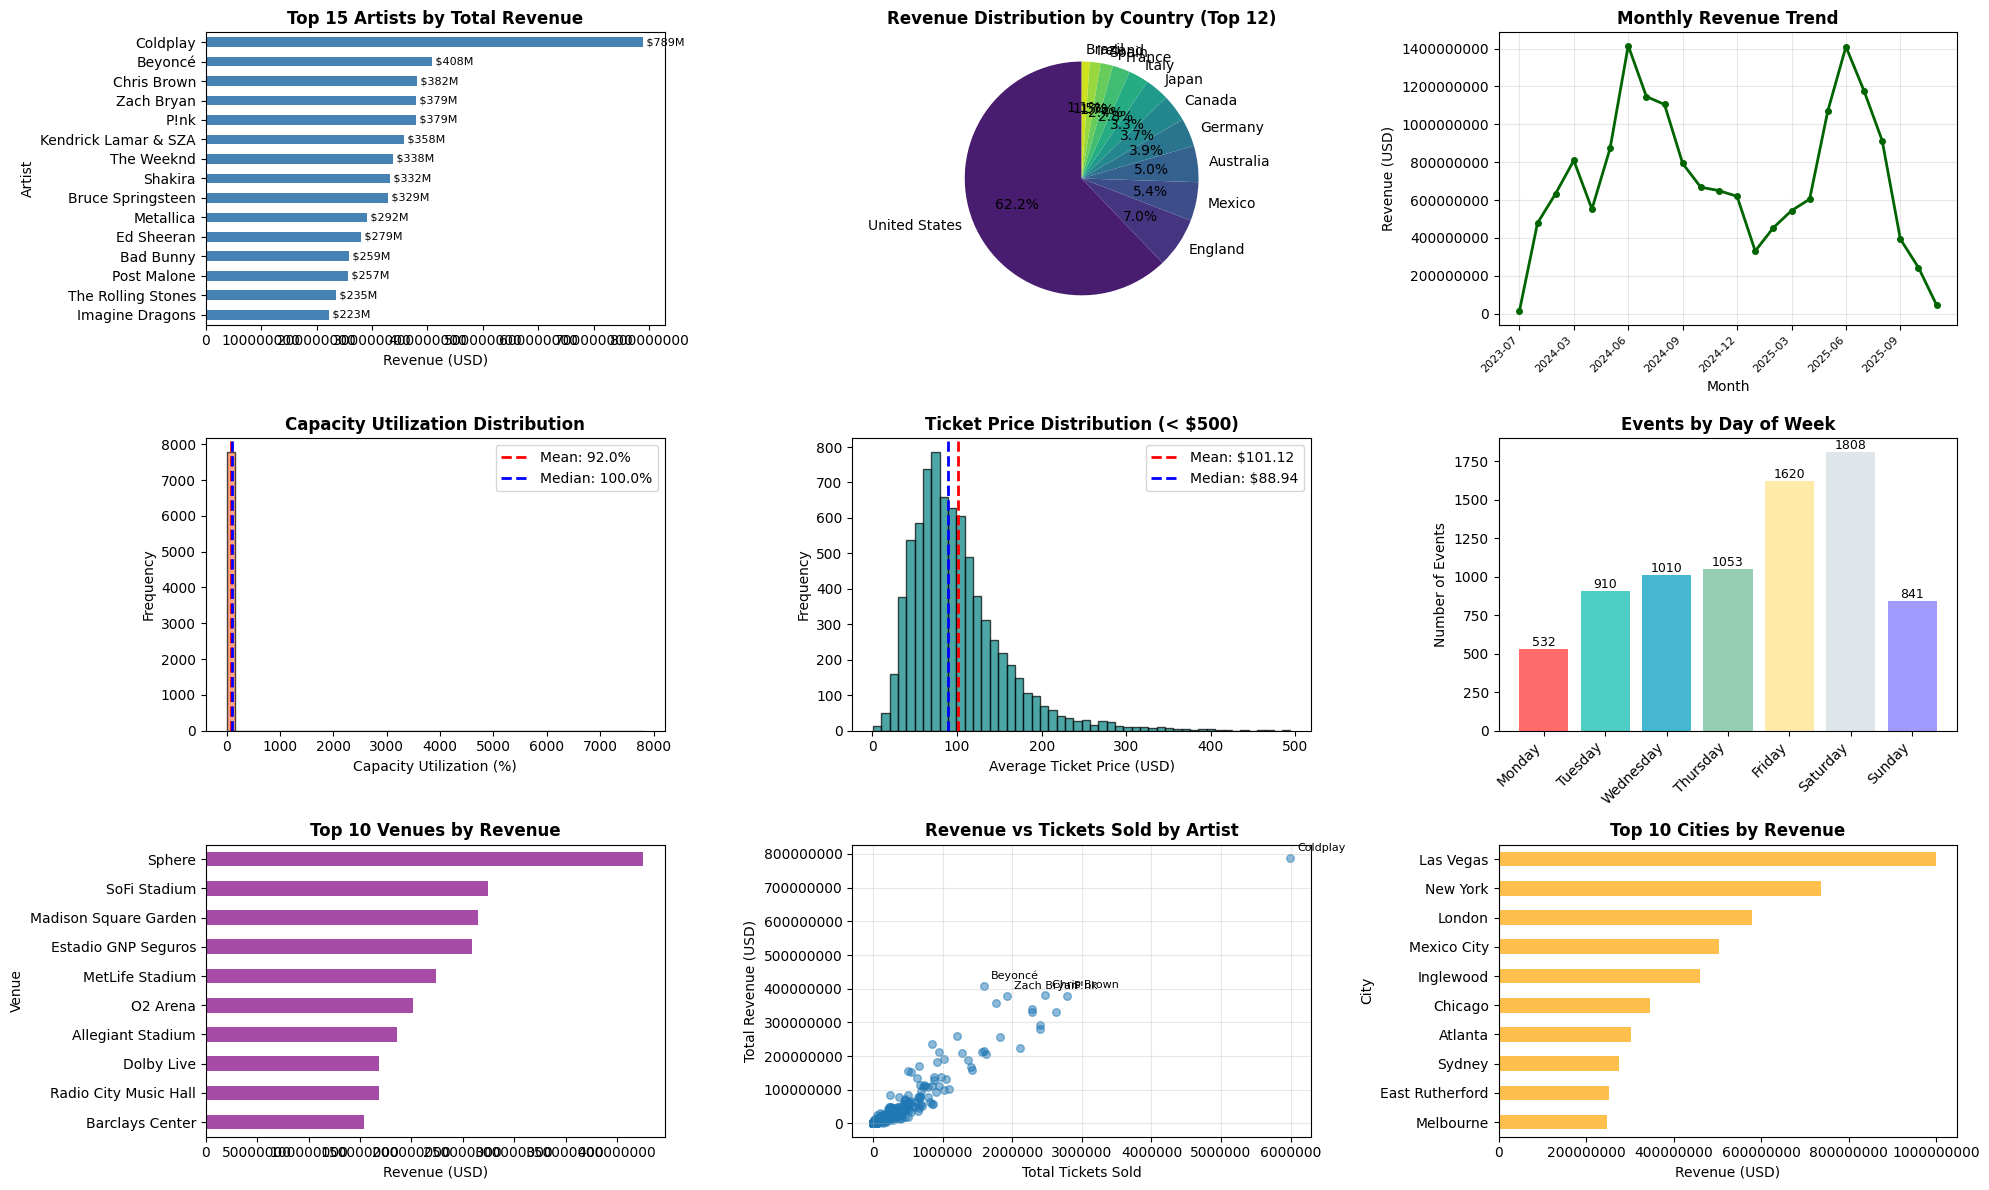

In [125]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Top 15 Artists by Revenue
ax1 = plt.subplot(3, 3, 1)
top_artists = df.groupby('Artist')['Revenue (USD)'].sum().sort_values(ascending=True).tail(15)
top_artists.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Revenue (USD)', fontsize=10)
ax1.set_title('Top 15 Artists by Total Revenue', fontsize=12, fontweight='bold')
ax1.ticklabel_format(style='plain', axis='x')
for i, v in enumerate(top_artists.values):
    ax1.text(v, i, f' ${v/1e6:.0f}M', va='center', fontsize=8)

# 2. Revenue by Country (Top 12)
ax2 = plt.subplot(3, 3, 2)
country_revenue = df.groupby('Country')['Revenue (USD)'].sum().sort_values(ascending=False).head(12)
colors = sns.color_palette('viridis', len(country_revenue))
ax2.pie(country_revenue.values, labels=country_revenue.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Revenue Distribution by Country (Top 12)', fontsize=12, fontweight='bold')

# 3. Monthly Revenue Trend
ax3 = plt.subplot(3, 3, 3)
monthly_revenue = df.groupby('Year-Month')['Revenue (USD)'].sum()
monthly_revenue_df = monthly_revenue.to_frame().reset_index()
monthly_revenue_df['Year-Month'] = monthly_revenue_df['Year-Month'].astype(str)
ax3.plot(range(len(monthly_revenue_df)), monthly_revenue_df['Revenue (USD)'], marker='o', linewidth=2, markersize=4, color='darkgreen')
ax3.set_xlabel('Month', fontsize=10)
ax3.set_ylabel('Revenue (USD)', fontsize=10)
ax3.set_title('Monthly Revenue Trend', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.ticklabel_format(style='plain', axis='y')
# Show every 3rd month label
step = max(1, len(monthly_revenue_df) // 8)
ax3.set_xticks(range(0, len(monthly_revenue_df), step))
ax3.set_xticklabels(monthly_revenue_df['Year-Month'].iloc[::step], rotation=45, ha='right', fontsize=8)

# 4. Capacity Utilization Distribution
ax4 = plt.subplot(3, 3, 4)
ax4.hist(df['%'] * 100, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax4.axvline(df['%'].mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {df["%"].mean()*100:.1f}%')
ax4.axvline(df['%'].median() * 100, color='blue', linestyle='--', linewidth=2, label=f'Median: {df["%"].median()*100:.1f}%')
ax4.set_xlabel('Capacity Utilization (%)', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Capacity Utilization Distribution', fontsize=12, fontweight='bold')
ax4.legend()

# 5. Ticket Price Distribution
ax5 = plt.subplot(3, 3, 5)
# Remove extreme outliers for better visualization
price_data = df['Avg Ticket Price'][df['Avg Ticket Price'] < 500]
ax5.hist(price_data, bins=50, color='teal', edgecolor='black', alpha=0.7)
ax5.axvline(df['Avg Ticket Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["Avg Ticket Price"].mean():.2f}')
ax5.axvline(df['Avg Ticket Price'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: ${df["Avg Ticket Price"].median():.2f}')
ax5.set_xlabel('Average Ticket Price (USD)', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_title('Ticket Price Distribution (< $500)', fontsize=12, fontweight='bold')
ax5.legend()

# 6. Events by Day of Week
ax6 = plt.subplot(3, 3, 6)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['DayOfWeek'].value_counts().reindex(day_order)
bars = ax6.bar(range(len(day_counts)), day_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DFE6E9', '#A29BFE'])
ax6.set_xticks(range(len(day_counts)))
ax6.set_xticklabels(day_counts.index, rotation=45, ha='right')
ax6.set_ylabel('Number of Events', fontsize=10)
ax6.set_title('Events by Day of Week', fontsize=12, fontweight='bold')
for i, v in enumerate(day_counts.values):
    ax6.text(i, v, str(v), ha='center', va='bottom', fontsize=9)

# 7. Top 10 Venues by Revenue
ax7 = plt.subplot(3, 3, 7)
top_venues = df.groupby('Venue')['Revenue (USD)'].sum().sort_values(ascending=True).tail(10)
top_venues.plot(kind='barh', ax=ax7, color='purple', alpha=0.7)
ax7.set_xlabel('Revenue (USD)', fontsize=10)
ax7.set_title('Top 10 Venues by Revenue', fontsize=12, fontweight='bold')
ax7.ticklabel_format(style='plain', axis='x')

# 8. Revenue vs Tickets Sold (scatter plot with top artists)
ax8 = plt.subplot(3, 3, 8)
artist_stats = df.groupby('Artist').agg({'Revenue (USD)': 'sum', 'Tickets Sold': 'sum'})
ax8.scatter(artist_stats['Tickets Sold'], artist_stats['Revenue (USD)'], alpha=0.5, s=30)
# Annotate top 5
top5 = artist_stats.nlargest(5, 'Revenue (USD)')
for artist, row in top5.iterrows():
    ax8.annotate(artist, (row['Tickets Sold'], row['Revenue (USD)']),
                fontsize=8, xytext=(5, 5), textcoords='offset points')
ax8.set_xlabel('Total Tickets Sold', fontsize=10)
ax8.set_ylabel('Total Revenue (USD)', fontsize=10)
ax8.set_title('Revenue vs Tickets Sold by Artist', fontsize=12, fontweight='bold')
ax8.ticklabel_format(style='plain', axis='both')
ax8.grid(True, alpha=0.3)

# 9. Top 10 Cities by Revenue
ax9 = plt.subplot(3, 3, 9)
top_cities = df.groupby('City')['Revenue (USD)'].sum().sort_values(ascending=True).tail(10)
top_cities.plot(kind='barh', ax=ax9, color='orange', alpha=0.7)
ax9.set_xlabel('Revenue (USD)', fontsize=10)
ax9.set_title('Top 10 Cities by Revenue', fontsize=12, fontweight='bold')
ax9.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.savefig(image_path + 'concert_eda_dashboard.png', dpi=300, bbox_inches='tight')

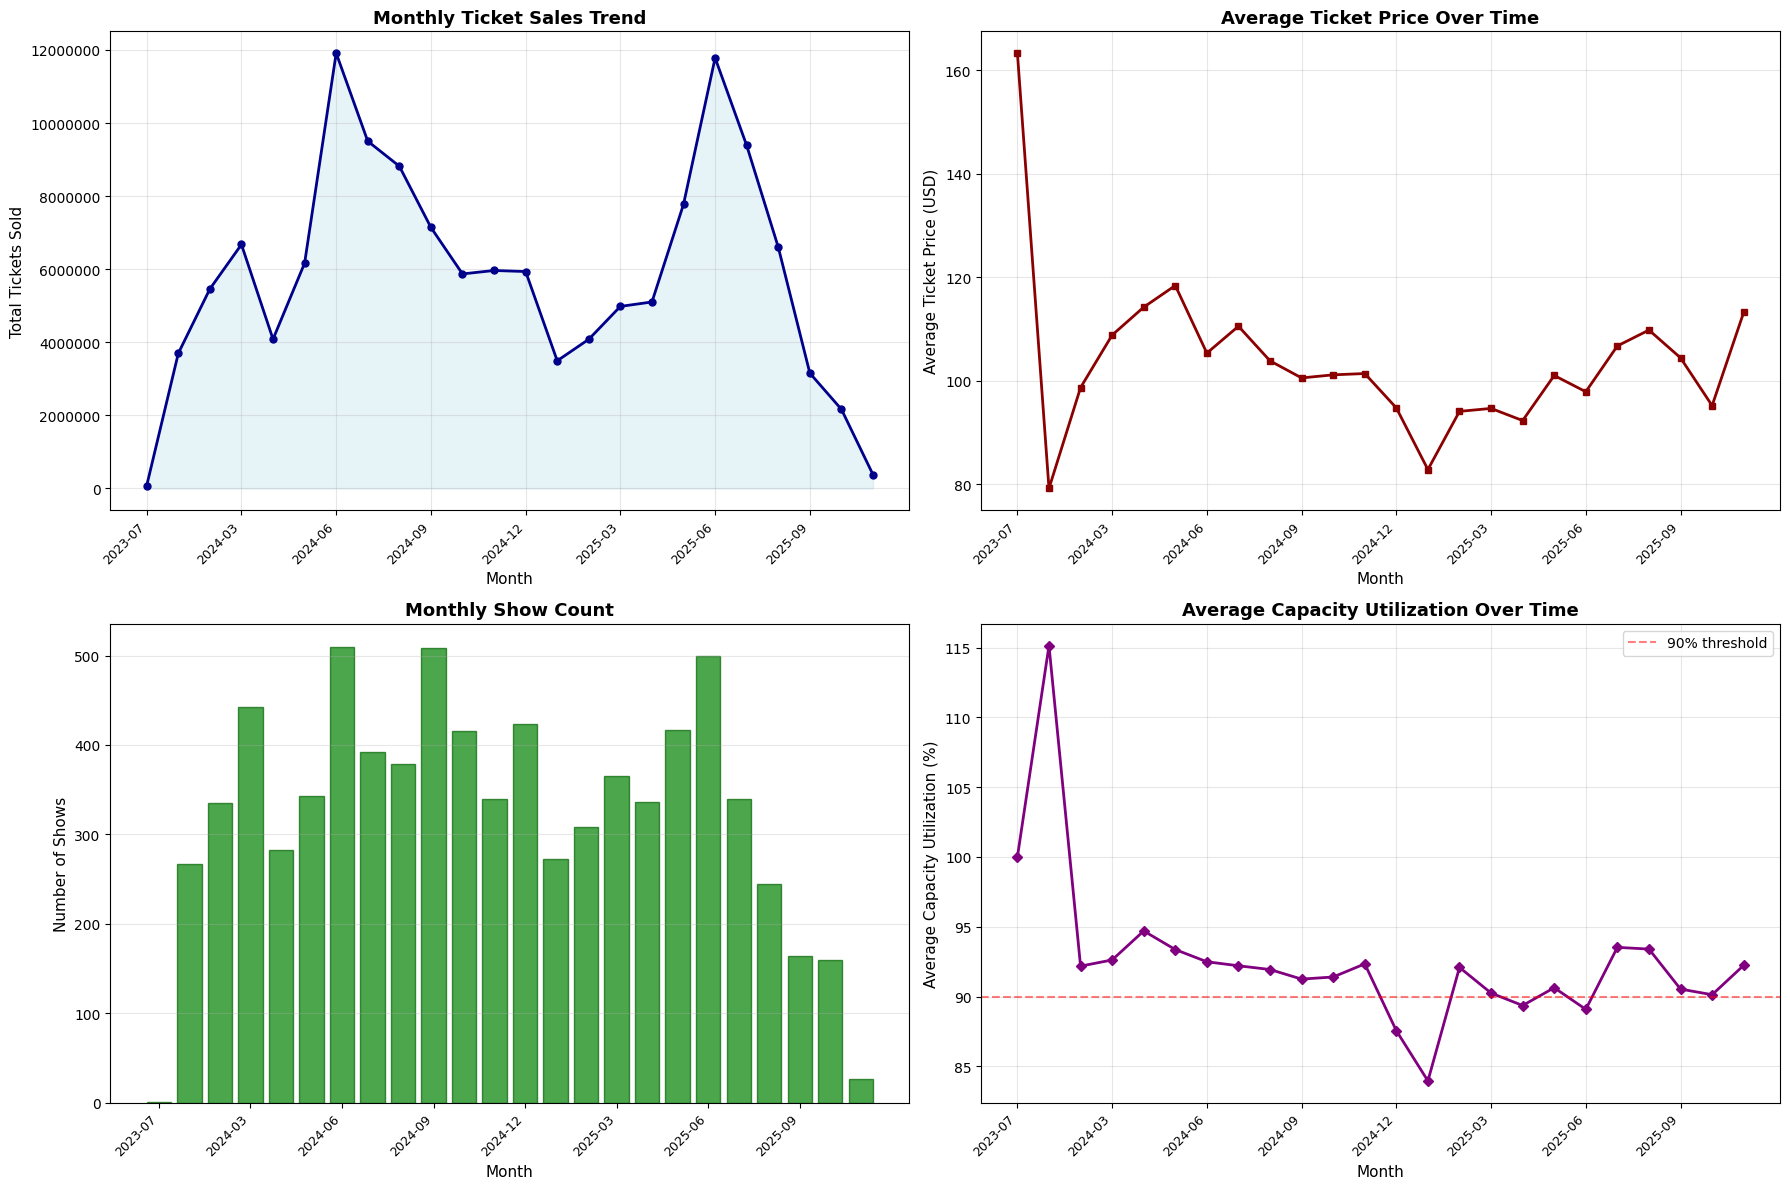

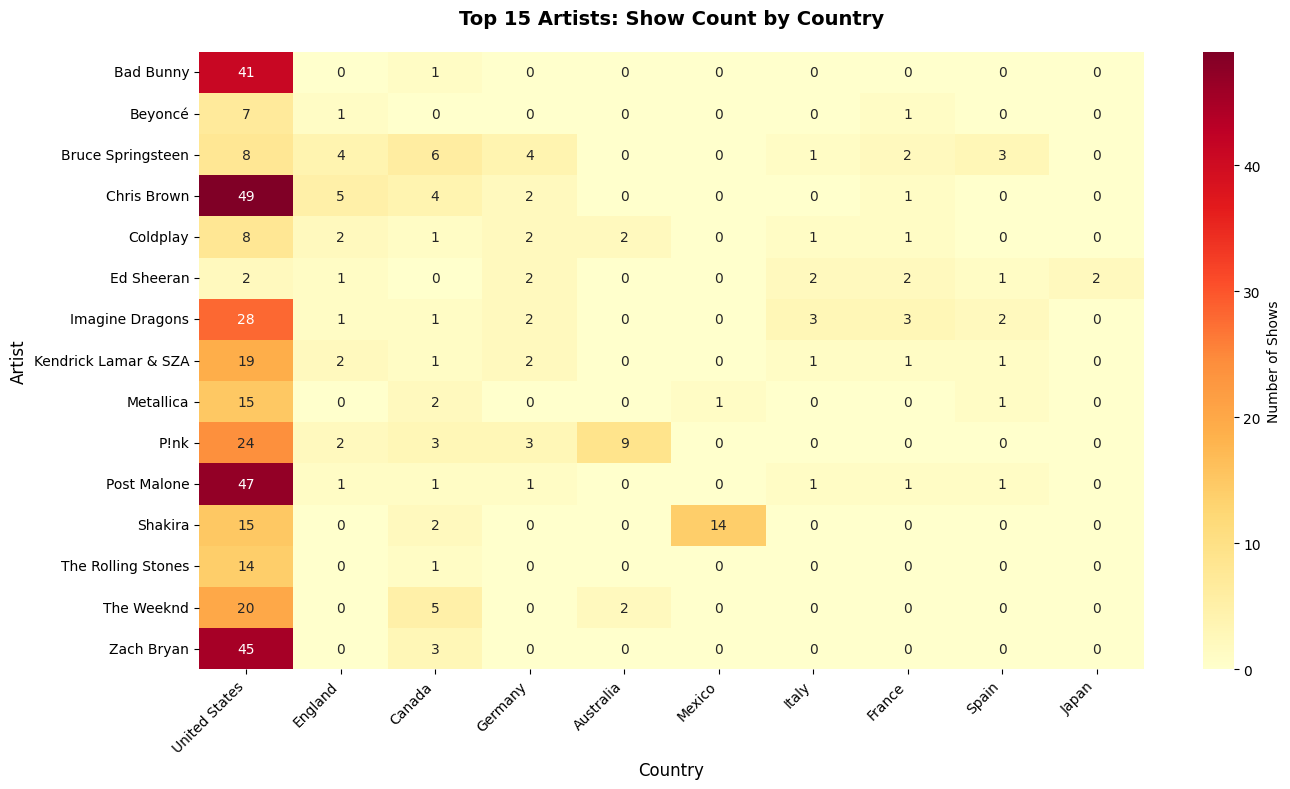

In [126]:
# Create figure for time series analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Monthly ticket sales
monthly_tickets = df.groupby(df['Event Date'].dt.to_period('M'))['Tickets Sold'].sum()
monthly_tickets_df = monthly_tickets.to_frame().reset_index()
monthly_tickets_df['Event Date'] = monthly_tickets_df['Event Date'].astype(str)

axes[0, 0].plot(range(len(monthly_tickets_df)), monthly_tickets_df['Tickets Sold'],
                marker='o', linewidth=2, markersize=5, color='darkblue')
axes[0, 0].fill_between(range(len(monthly_tickets_df)), monthly_tickets_df['Tickets Sold'],
                         alpha=0.3, color='lightblue')
axes[0, 0].set_xlabel('Month', fontsize=11)
axes[0, 0].set_ylabel('Total Tickets Sold', fontsize=11)
axes[0, 0].set_title('Monthly Ticket Sales Trend', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
step = max(1, len(monthly_tickets_df) // 8)
axes[0, 0].set_xticks(range(0, len(monthly_tickets_df), step))
axes[0, 0].set_xticklabels(monthly_tickets_df['Event Date'].iloc[::step], rotation=45, ha='right', fontsize=9)
axes[0, 0].ticklabel_format(style='plain', axis='y')

# 2. Average ticket price over time
monthly_avg_price = df.groupby(df['Event Date'].dt.to_period('M'))['Avg Ticket Price'].mean()
monthly_price_df = monthly_avg_price.to_frame().reset_index()
monthly_price_df['Event Date'] = monthly_price_df['Event Date'].astype(str)

axes[0, 1].plot(range(len(monthly_price_df)), monthly_price_df['Avg Ticket Price'],
                marker='s', linewidth=2, markersize=5, color='darkred')
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Average Ticket Price (USD)', fontsize=11)
axes[0, 1].set_title('Average Ticket Price Over Time', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, len(monthly_price_df), step))
axes[0, 1].set_xticklabels(monthly_price_df['Event Date'].iloc[::step], rotation=45, ha='right', fontsize=9)

# 3. Number of shows per month
monthly_shows = df.groupby(df['Event Date'].dt.to_period('M')).size()
monthly_shows_df = monthly_shows.to_frame(name='Shows').reset_index()
monthly_shows_df['Event Date'] = monthly_shows_df['Event Date'].astype(str)

axes[1, 0].bar(range(len(monthly_shows_df)), monthly_shows_df['Shows'],
               color='green', alpha=0.7, edgecolor='darkgreen')
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Number of Shows', fontsize=11)
axes[1, 0].set_title('Monthly Show Count', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(range(0, len(monthly_shows_df), step))
axes[1, 0].set_xticklabels(monthly_shows_df['Event Date'].iloc[::step], rotation=45, ha='right', fontsize=9)

# 4. Average capacity utilization over time
monthly_capacity = df.groupby(df['Event Date'].dt.to_period('M'))['%'].mean() * 100
monthly_capacity_df = monthly_capacity.to_frame(name='Capacity %').reset_index()
monthly_capacity_df['Event Date'] = monthly_capacity_df['Event Date'].astype(str)

axes[1, 1].plot(range(len(monthly_capacity_df)), monthly_capacity_df['Capacity %'],
                marker='D', linewidth=2, markersize=5, color='purple')
axes[1, 1].axhline(y=90, color='r', linestyle='--', alpha=0.5, label='90% threshold')
axes[1, 1].set_xlabel('Month', fontsize=11)
axes[1, 1].set_ylabel('Average Capacity Utilization (%)', fontsize=11)
axes[1, 1].set_title('Average Capacity Utilization Over Time', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, len(monthly_capacity_df), step))
axes[1, 1].set_xticklabels(monthly_capacity_df['Event Date'].iloc[::step], rotation=45, ha='right', fontsize=9)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(image_path + 'time_series_analysis.png', dpi=300, bbox_inches='tight')

# Create a heatmap for genre/region analysis
fig, ax = plt.subplots(figsize=(14, 8))

# Top countries and top artists cross-tabulation
top_countries = df['Country'].value_counts().head(10).index
top_artists = df.groupby('Artist')['Revenue (USD)'].sum().sort_values(ascending=False).head(15).index

# Create cross-tab
ct = pd.crosstab(
    df[df['Artist'].isin(top_artists)]['Artist'],
    df[df['Artist'].isin(top_artists)]['Country']
)
ct = ct[top_countries]

sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Number of Shows'})
ax.set_title('Top 15 Artists: Show Count by Country', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Artist', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(image_path + 'artist_country_heatmap.png', dpi=300, bbox_inches='tight')

/tmp/ipython-input-24582619.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df_top_countries[df_top_countries['Country'] == country]['Revenue (USD)'].values / 1e6


Advanced analysis visualization saved!


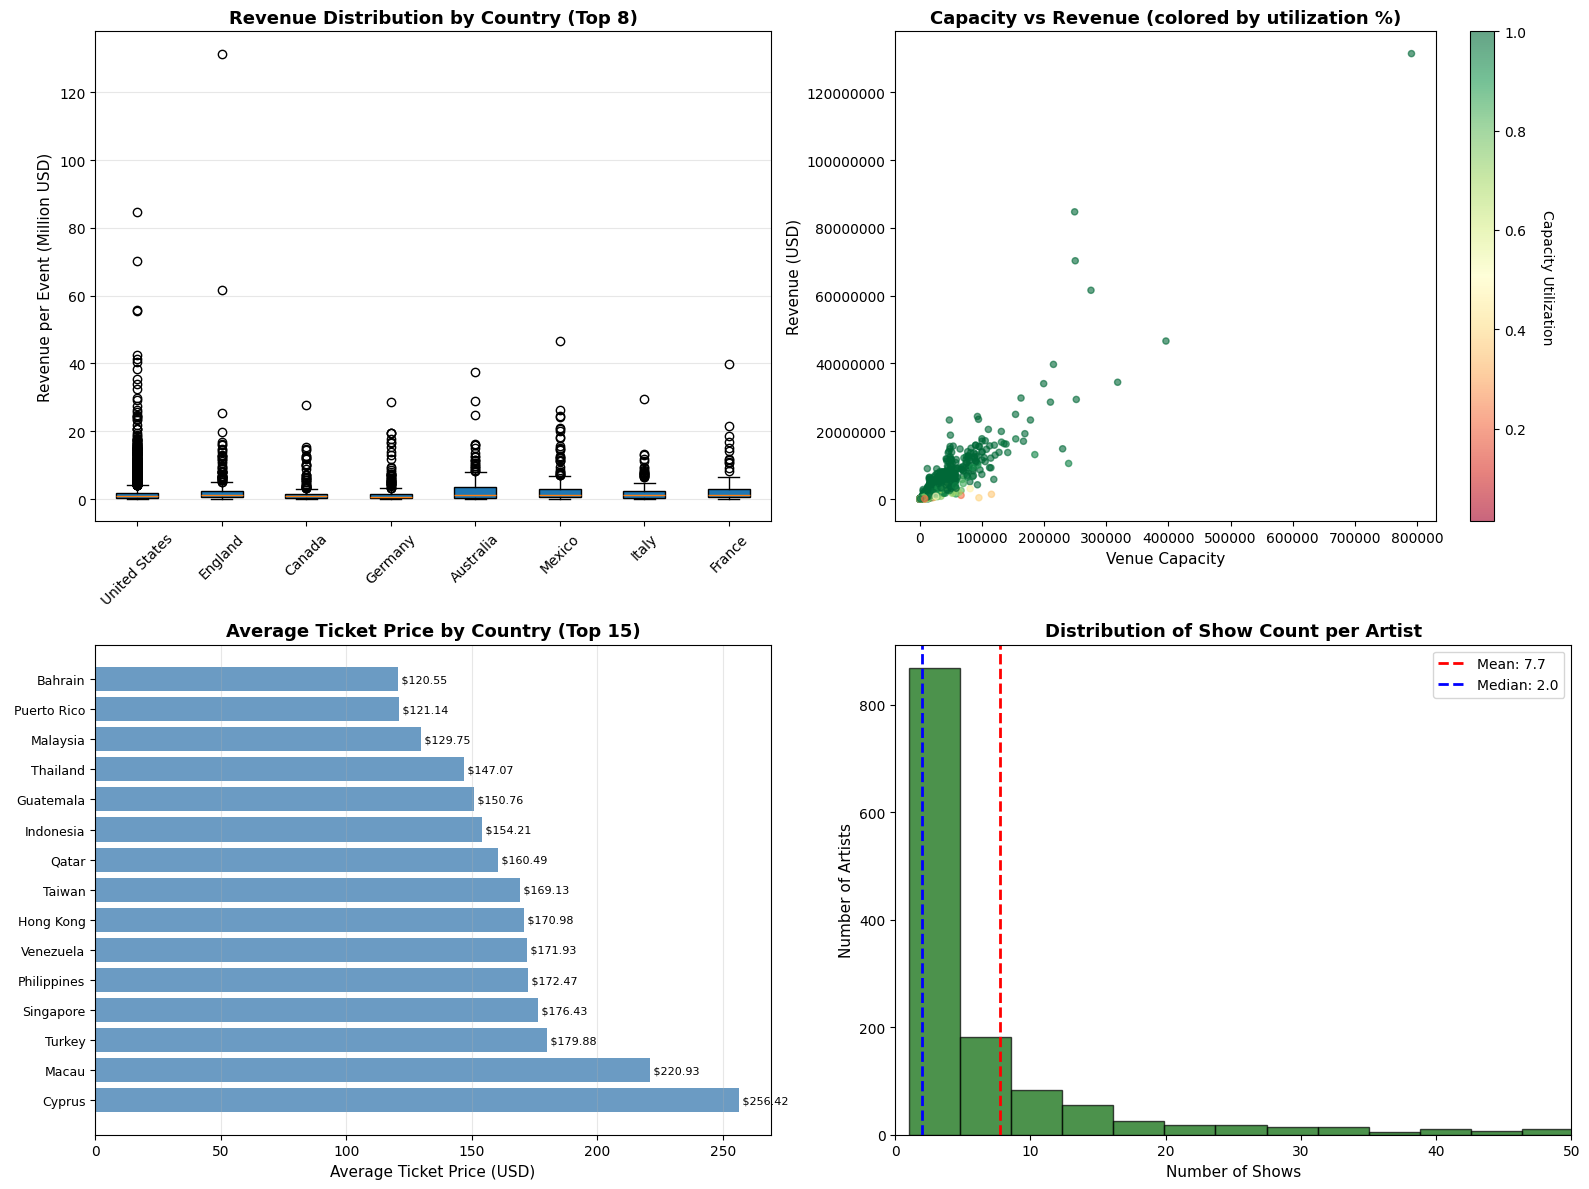

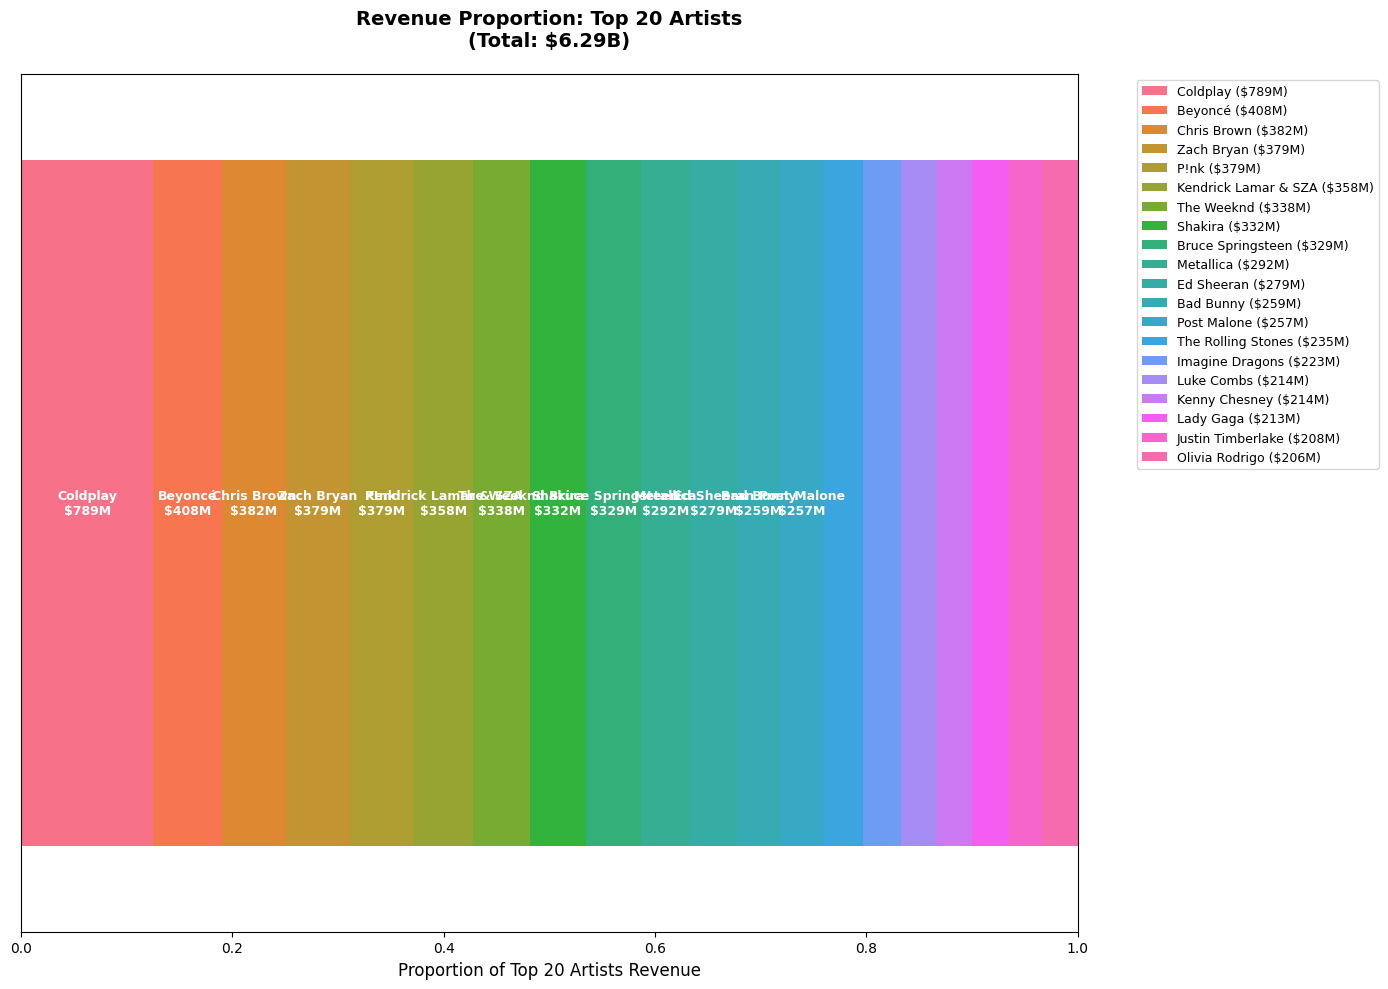

In [127]:
# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot of revenue by top countries
top_countries = df['Country'].value_counts().head(8).index
df_top_countries = df[df['Country'].isin(top_countries)]

axes[0, 0].boxplot([df_top_countries[df_top_countries['Country'] == country]['Revenue (USD)'].values / 1e6
                     for country in top_countries],
                    labels=top_countries, patch_artist=True)
axes[0, 0].set_ylabel('Revenue per Event (Million USD)', fontsize=11)
axes[0, 0].set_title('Revenue Distribution by Country (Top 8)', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Scatter: Capacity vs Revenue
sample = df.sample(min(2000, len(df)), random_state=42)
scatter = axes[0, 1].scatter(sample['Capacity'], sample['Revenue (USD)'],
                             c=sample['%'], cmap='RdYlGn', alpha=0.6, s=20)
axes[0, 1].set_xlabel('Venue Capacity', fontsize=11)
axes[0, 1].set_ylabel('Revenue (USD)', fontsize=11)
axes[0, 1].set_title('Capacity vs Revenue (colored by utilization %)', fontsize=13, fontweight='bold')
axes[0, 1].ticklabel_format(style='plain', axis='both')
cbar = plt.colorbar(scatter, ax=axes[0, 1])
cbar.set_label('Capacity Utilization', rotation=270, labelpad=20)

# 3. Average ticket price by top countries
country_price = df.groupby('Country')['Avg Ticket Price'].mean().sort_values(ascending=False).head(15)
axes[1, 0].barh(range(len(country_price)), country_price.values, color='steelblue', alpha=0.8)
axes[1, 0].set_yticks(range(len(country_price)))
axes[1, 0].set_yticklabels(country_price.index, fontsize=9)
axes[1, 0].set_xlabel('Average Ticket Price (USD)', fontsize=11)
axes[1, 0].set_title('Average Ticket Price by Country (Top 15)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(country_price.values):
    axes[1, 0].text(v, i, f' ${v:.2f}', va='center', fontsize=8)

# 4. Shows per artist distribution
shows_per_artist = df.groupby('Artist')['Shows'].sum()
axes[1, 1].hist(shows_per_artist, bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Number of Shows', fontsize=11)
axes[1, 1].set_ylabel('Number of Artists', fontsize=11)
axes[1, 1].set_title('Distribution of Show Count per Artist', fontsize=13, fontweight='bold')
axes[1, 1].axvline(shows_per_artist.mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {shows_per_artist.mean():.1f}')
axes[1, 1].axvline(shows_per_artist.median(), color='blue', linestyle='--',
                   linewidth=2, label=f'Median: {shows_per_artist.median():.1f}')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 50)

plt.tight_layout()
plt.savefig(image_path +'advanced_analysis.png', dpi=300, bbox_inches='tight')
print("Advanced analysis visualization saved!")

# Create one more: revenue breakdown treemap-style visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Get top 20 artists
top20_artists = df.groupby('Artist')['Revenue (USD)'].sum().sort_values(ascending=False).head(20)
colors = sns.color_palette('husl', len(top20_artists))

# Create horizontal stacked bar representing proportions
cumsum = 0
for idx, (artist, revenue) in enumerate(top20_artists.items()):
    width = revenue / top20_artists.sum()
    ax.barh(0, width, left=cumsum, height=0.8,
            label=f'{artist} (${revenue/1e6:.0f}M)', color=colors[idx])

    # Add text if segment is large enough
    if width > 0.04:
        ax.text(cumsum + width/2, 0, f'{artist}\n${revenue/1e6:.0f}M',
               ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    cumsum += width

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)
ax.set_yticks([])
ax.set_xlabel('Proportion of Top 20 Artists Revenue', fontsize=12)
ax.set_title('Revenue Proportion: Top 20 Artists\n(Total: ${:.2f}B)'.format(top20_artists.sum()/1e9),
             fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig(image_path + 'revenue_proportion_top20.png', dpi=300, bbox_inches='tight')

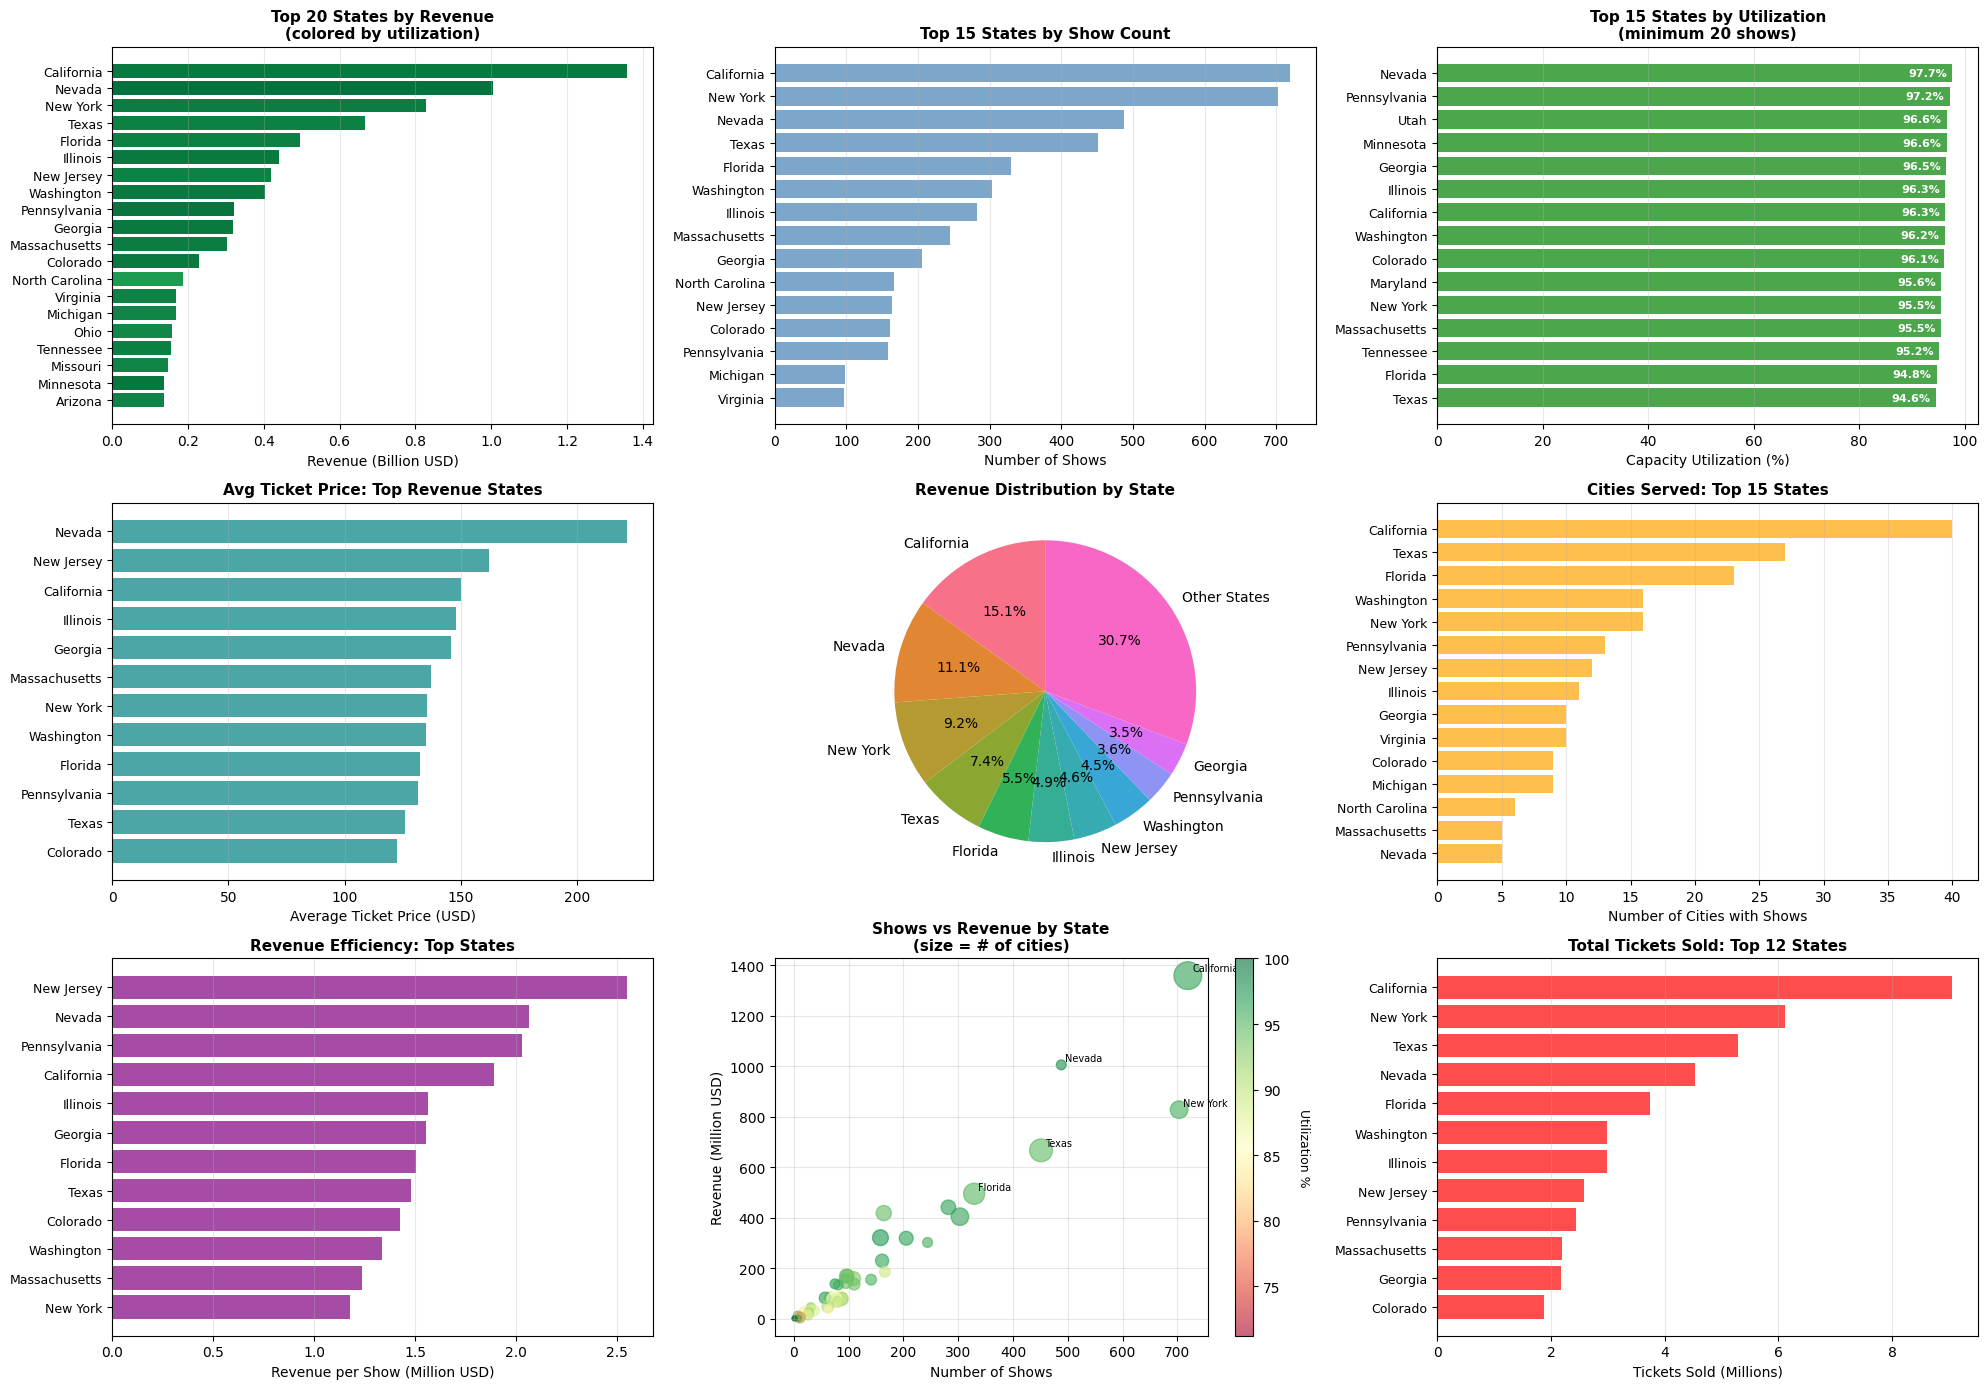

In [129]:
# Load the data with states
df = pd.read_csv(data_path + 'us_only_with_states.csv')
df['Event Date'] = pd.to_datetime(df['Event Date'])

# Filter out unmapped states
df_states = df[df['State'].notna()].copy()

# Calculate state-level metrics
state_stats = df_states.groupby('State').agg({
    'Shows': 'sum',
    'Revenue (USD)': 'sum',
    'Tickets Sold': 'sum',
    'Capacity': 'sum',
    'City': 'nunique',
    'Venue': 'nunique'
})

# Calculate utilization
state_stats['Utilization %'] = (state_stats['Tickets Sold'] / state_stats['Capacity'] * 100)
state_stats['Avg Ticket Price'] = state_stats['Revenue (USD)'] / state_stats['Tickets Sold']
state_stats['Revenue per Show'] = state_stats['Revenue (USD)'] / state_stats['Shows']

state_stats.columns = ['Shows', 'Revenue', 'Tickets Sold', 'Capacity',
                        'Cities', 'Venues', 'Utilization %', 'Avg Ticket Price', 'Revenue per Show']

state_stats = state_stats.sort_values('Revenue', ascending=False)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 14))

# 1. Top 20 states by revenue
ax1 = plt.subplot(3, 3, 1)
top20 = state_stats.head(20).sort_values('Revenue', ascending=True)
colors = plt.cm.RdYlGn(top20['Utilization %'] / 100)
bars = ax1.barh(range(len(top20)), top20['Revenue'] / 1e9, color=colors)
ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20.index, fontsize=9)
ax1.set_xlabel('Revenue (Billion USD)', fontsize=10)
ax1.set_title('Top 20 States by Revenue\n(colored by utilization)', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# 2. Shows distribution by state
ax2 = plt.subplot(3, 3, 2)
top15_shows = state_stats.head(15).sort_values('Shows', ascending=True)
ax2.barh(range(len(top15_shows)), top15_shows['Shows'], color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(top15_shows)))
ax2.set_yticklabels(top15_shows.index, fontsize=9)
ax2.set_xlabel('Number of Shows', fontsize=10)
ax2.set_title('Top 15 States by Show Count', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Utilization by state
ax3 = plt.subplot(3, 3, 3)
top15_util = state_stats[state_stats['Shows'] >= 20].sort_values('Utilization %', ascending=True).tail(15)
bars = ax3.barh(range(len(top15_util)), top15_util['Utilization %'], color='green', alpha=0.7)
ax3.set_yticks(range(len(top15_util)))
ax3.set_yticklabels(top15_util.index, fontsize=9)
ax3.set_xlabel('Capacity Utilization (%)', fontsize=10)
ax3.set_title('Top 15 States by Utilization\n(minimum 20 shows)', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(top15_util['Utilization %'].values):
    ax3.text(v - 1, i, f'{v:.1f}%', va='center', ha='right', fontsize=8, color='white', fontweight='bold')

# 4. Average ticket price by state
ax4 = plt.subplot(3, 3, 4)
top12_price = state_stats.head(12).sort_values('Avg Ticket Price', ascending=True)
ax4.barh(range(len(top12_price)), top12_price['Avg Ticket Price'], color='teal', alpha=0.7)
ax4.set_yticks(range(len(top12_price)))
ax4.set_yticklabels(top12_price.index, fontsize=9)
ax4.set_xlabel('Average Ticket Price (USD)', fontsize=10)
ax4.set_title('Avg Ticket Price: Top Revenue States', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Revenue distribution pie chart (top 10 states)
ax5 = plt.subplot(3, 3, 5)
top10_rev = state_stats.head(10)
other_rev = state_stats.iloc[10:]['Revenue'].sum()
pie_data = list(top10_rev['Revenue'].values) + [other_rev]
pie_labels = list(top10_rev.index) + ['Other States']
colors_pie = sns.color_palette('husl', len(pie_data))
ax5.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=colors_pie)
ax5.set_title('Revenue Distribution by State', fontsize=11, fontweight='bold')

# 6. Number of cities per state
ax6 = plt.subplot(3, 3, 6)
top15_cities = state_stats.head(15).sort_values('Cities', ascending=True)
ax6.barh(range(len(top15_cities)), top15_cities['Cities'], color='orange', alpha=0.7)
ax6.set_yticks(range(len(top15_cities)))
ax6.set_yticklabels(top15_cities.index, fontsize=9)
ax6.set_xlabel('Number of Cities with Shows', fontsize=10)
ax6.set_title('Cities Served: Top 15 States', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

# 7. Revenue per show by state
ax7 = plt.subplot(3, 3, 7)
top12_rps = state_stats.head(12).sort_values('Revenue per Show', ascending=True)
ax7.barh(range(len(top12_rps)), top12_rps['Revenue per Show'] / 1e6, color='purple', alpha=0.7)
ax7.set_yticks(range(len(top12_rps)))
ax7.set_yticklabels(top12_rps.index, fontsize=9)
ax7.set_xlabel('Revenue per Show (Million USD)', fontsize=10)
ax7.set_title('Revenue Efficiency: Top States', fontsize=11, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')

# 8. Scatter: Shows vs Revenue
ax8 = plt.subplot(3, 3, 8)
scatter = ax8.scatter(state_stats['Shows'], state_stats['Revenue'] / 1e6,
                     s=state_stats['Cities']*10, alpha=0.6,
                     c=state_stats['Utilization %'], cmap='RdYlGn')
ax8.set_xlabel('Number of Shows', fontsize=10)
ax8.set_ylabel('Revenue (Million USD)', fontsize=10)
ax8.set_title('Shows vs Revenue by State\n(size = # of cities)', fontsize=11, fontweight='bold')
ax8.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax8)
cbar.set_label('Utilization %', rotation=270, labelpad=15, fontsize=9)

# Annotate top 5
for state, row in state_stats.head(5).iterrows():
    ax8.annotate(state, (row['Shows'], row['Revenue'] / 1e6),
                fontsize=7, xytext=(3, 3), textcoords='offset points')

# 9. Tickets sold by state
ax9 = plt.subplot(3, 3, 9)
top12_tickets = state_stats.head(12).sort_values('Tickets Sold', ascending=True)
ax9.barh(range(len(top12_tickets)), top12_tickets['Tickets Sold'] / 1e6, color='red', alpha=0.7)
ax9.set_yticks(range(len(top12_tickets)))
ax9.set_yticklabels(top12_tickets.index, fontsize=9)
ax9.set_xlabel('Tickets Sold (Millions)', fontsize=10)
ax9.set_title('Total Tickets Sold: Top 12 States', fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(image_path + 'us_states_analysis.png', dpi=300, bbox_inches='tight')

# Save state summary to CSV
state_stats.to_csv(data_path+'us_states_summary.csv')

## 📊 STEP 6: Initial Model Generation

In [138]:
"""
Linear Regression Models for Concert Data
==========================================
Model 1: Predicting Revenue
Model 2: Predicting Capacity Utilization
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# LOAD DATA
# ============================================================================

print("="*80)
print("LINEAR REGRESSION MODELS - CONCERT DATA")
print("="*80)

df = pd.read_csv(data_path + 'us_only_with_states.csv')
print(f"\nLoaded {len(df):,} US events with valid states and genres")

# ============================================================================
# DATA PREPARATION
# ============================================================================

print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

model_df = df.copy()

# Temporal features
model_df['Event Date'] = pd.to_datetime(model_df['Event Date'], errors='coerce')
model_df['DayOfWeek_Num'] = model_df['Event Date'].dt.dayofweek
model_df['IsWeekend'] = model_df['DayOfWeek_Num'].isin([5, 6]).astype(int)

# Ensure Genre_Clean is created for get_dummies
model_df['Genre_Clean'] = model_df['Genre'].fillna('Unknown')

# This automatically creates all the columns for one-hot encoding
# model_df = pd.get_dummies(model_df, columns=['State', 'Genre_Clean', 'Artist'],
#                           prefix=['State', 'Genre', 'Artist'])
model_df = pd.get_dummies(model_df, columns=['State', 'Genre_Clean',],
                          prefix=['State', 'Genre'])

# Construct the features list dynamically after get_dummies has been applied
# Include original numerical/temporal features
features = ['Capacity', 'Month', 'DayOfWeek_Num', 'IsWeekend', 'Shows']

# Add all one-hot encoded columns generated by pd.get_dummies
# We filter columns that start with the prefixes used for one-hot encoding
encoded_cols = [col for col in model_df.columns if col.startswith(('State_', 'Genre_'))]
features.extend(encoded_cols)

# Clean data
clean_df = model_df[features + ['Revenue (USD)', 'Capacity Utilization (%)']].dropna()
print(f"\n✓ Clean dataset: {len(clean_df):,} rows")

clean_df.head()

LINEAR REGRESSION MODELS - CONCERT DATA

Loaded 4,666 US events with valid states and genres

DATA PREPARATION

✓ Clean dataset: 4,666 rows


,Capacity,Month,DayOfWeek_Num,IsWeekend,Shows,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,State_California,...,Genre_tropical house,Genre_uk drill,Genre_villancicos,Genre_vocal jazz,Genre_witch house,Genre_worship,Genre_yacht rock,Genre_zouk,Revenue (USD),Capacity Utilization (%)
0,5513,11,6,1,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,650127,100.00
1,2362,11,6,1,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,88300,90.69
2,25628,11,5,1,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2582575,100.00
3,18456,11,4,0,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,970582,77.83
4,8531,11,4,0,1,False,False,False,False,True,...,False,False,False,False,False,False,False,False,725388,100.00


In [139]:
# ============================================================================
# MODEL 1: REVENUE PREDICTION
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: PREDICTING REVENUE")
print("="*80)

X = clean_df[features]
y = clean_df['Revenue (USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain: {len(X_train):,} | Test: {len(X_test):,}")

# Train
model_rev = LinearRegression()
model_rev.fit(X_train, y_train)

# Predict
y_pred_test = model_rev.predict(X_test)

# Evaluate
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")
print(f"  RMSE:      ${test_rmse:,.0f}")
print(f"  MAE:       ${test_mae:,.0f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model_rev.coef_
})
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 25 Features:")
for idx, row in feature_importance.head(25).iterrows():
    print(f"  {row['Feature']:20s} {row['Coefficient']:>15,.2f}")


MODEL 1: PREDICTING REVENUE

Train: 3,732 | Test: 934

Test Set Performance:
  R² Score:  0.8123 (81.23% variance explained)
  RMSE:      $1,432,499
  MAE:       $858,215

Top 25 Features:
  Genre_tejano          -30,700,805.97
  Genre_progressive rock    4,011,650.82
  Genre_art pop           3,504,573.17
  Genre_children's music   -2,980,169.47
  Genre_hard rock        -2,827,001.41
  Genre_rock              2,446,919.09
  Genre_classic rock      2,212,725.06
  State_Alaska           -2,102,536.03
  Genre_metal            -1,582,017.79
  State_Nevada            1,574,585.74
  Genre_riddim           -1,409,903.67
  Genre_soft rock         1,405,706.72
  Genre_musicals         -1,394,066.92
  Genre_melodic techno   -1,364,784.11
  Genre_punk             -1,354,380.96
  Genre_house            -1,216,877.37
  Genre_garage rock       1,202,407.63
  Genre_newgrass          1,179,270.66
  State_Vermont           1,130,627.25
  Genre_power pop         1,120,339.18
  Genre_folk pop         -

In [133]:
# ============================================================================
# MODEL 2: CAPACITY UTILIZATION PREDICTION
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: PREDICTING CAPACITY UTILIZATION")
print("="*80)

y_cap = clean_df['Capacity Utilization (%)']

X_train_cap, X_test_cap, y_train_cap, y_test_cap = train_test_split(
    X, y_cap, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train_cap):,} | Test: {len(X_test_cap):,}")

# Train
model_cap = LinearRegression()
model_cap.fit(X_train_cap, y_train_cap)

# Predict
y_pred_cap = model_cap.predict(X_test_cap)

# Evaluate
test_r2_cap = r2_score(y_test_cap, y_pred_cap)
test_rmse_cap = np.sqrt(mean_squared_error(y_test_cap, y_pred_cap))
test_mae_cap = mean_absolute_error(y_test_cap, y_pred_cap)

print("\nTest Set Performance:")
print(f"  R² Score:  {test_r2_cap:.4f} ({test_r2_cap*100:.2f}% variance explained)")
print(f"  RMSE:      {test_rmse_cap:.2f}%")
print(f"  MAE:       {test_mae_cap:.2f}%")

# Feature importance
feature_importance_cap = pd.DataFrame({
    'Feature': features,
    'Coefficient': model_cap.coef_
})
feature_importance_cap = feature_importance_cap.sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 25 Features:")
for idx, row in feature_importance_cap.head(25).iterrows():
    print(f"  {row['Feature']:20s} {row['Coefficient']:>15,.4f}")


MODEL 2: PREDICTING CAPACITY UTILIZATION

Train: 3,732 | Test: 934

Test Set Performance:
  R² Score:  0.1220 (12.20% variance explained)
  RMSE:      15.41%
  MAE:       10.56%

Top 25 Features:
  Genre_bassline              -77.7973
  Genre_drum and bass         -73.1230
  Genre_darkwave              -72.5209
  Genre_miami bass            -51.4971
  Genre_philly soul           -46.9576
  Genre_new wave              -46.6267
  Genre_indie folk            -43.3957
  Genre_thrash metal          -37.9540
  Genre_argentine trap        -37.8761
  Genre_new orleans bounce        -37.5508
  Genre_ska                   -37.0897
  Genre_happy hardcore        -36.7354
  Genre_sexy drill            -34.2458
  Genre_doo-wop               -28.8808
  Genre_children's music        -26.0145
  Genre_p-pop                 -24.9625
  Genre_sertanejo             -24.0589
  Genre_villancicos           -23.4394
  Genre_acoustic pop          -23.1758
  Genre_cloud rap              21.1329
  Genre_nz reggae